# Graphs and Dataframes

## Datasets

In [1]:
import numpy as np
from pathlib import Path
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

def find_neighbors(G, node):
    successors = set(G.successors(node))
    predecessors = set(G.predecessors(node))
    neighbors = successors | predecessors
    return len(neighbors)

def read_net_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    nodes = {}
    n_states = 0
    create = True
    
    for line in lines:
        if line.strip() and not line.startswith('*'):  # Ignora le righe vuote e i commenti
            parts = line.strip().split()
            if len(parts) == 5:
                nodes[int(parts[0])-1] = [parts[1].replace('"', ''), float(parts[2]), float(parts[3])]
                n_states += 1
            elif len(parts) == 3:
                if create:
                    matrix = [[0 for _ in range(n_states)] for _ in range(n_states)]
                    create = False
                matrix[int(parts[0])-1][int(parts[1])-1] = float(parts[2])

    return nodes, matrix

In [2]:
dataset_folder = Path.cwd().joinpath("datasets")
data2018 = dataset_folder.joinpath("2018.net")

nodes, m2018 = read_net_file(data2018)

In [3]:
G2018 = nx.DiGraph()

for r in range(len(m2018)):
  for c in range(len(m2018[r])):
    if m2018[r][c]>0:
      G2018.add_edge(nodes[r][0], nodes[c][0], price=m2018[r][c])

print(G2018)

DiGraph with 161 nodes and 17030 edges


## Binary graph

In [4]:
Tot2018 = {'Imp':[sum(i) for i in m2018], 'Exp':[sum([m2018[j][i] for j in range(len(m2018))]) for i in range(len(m2018))], 'ImpPartners':[sum(1 for e in i if e > 0) for i in m2018], 'ExpPartners':[sum([1 for j in range(len(m2018)) if m2018[j][i] > 0]) for i in range(len(m2018))]}

threshold = 0.1

G2018bin = nx.DiGraph()


for r in range(len(m2018)):
  for c in range(len(m2018[r])):
    if (m2018[r][c]>0) and ((m2018[r][c]>threshold*Tot2018['Imp'][r])) and ((m2018[r][c]>threshold*Tot2018['Exp'][c])):
      G2018bin.add_edge(nodes[r][0], nodes[c][0], importance='both', price=m2018[r][c])
    elif (m2018[r][c]>0) and ((m2018[r][c]>threshold*Tot2018['Imp'][r])):
      G2018bin.add_edge(nodes[r][0], nodes[c][0], importance='import', price=m2018[r][c])
    elif (m2018[r][c]>0) and ((m2018[r][c]>threshold*Tot2018['Exp'][c])):
      G2018bin.add_edge(nodes[r][0], nodes[c][0], importance='export', price=m2018[r][c])

print(G2018bin)

DiGraph with 161 nodes and 547 edges


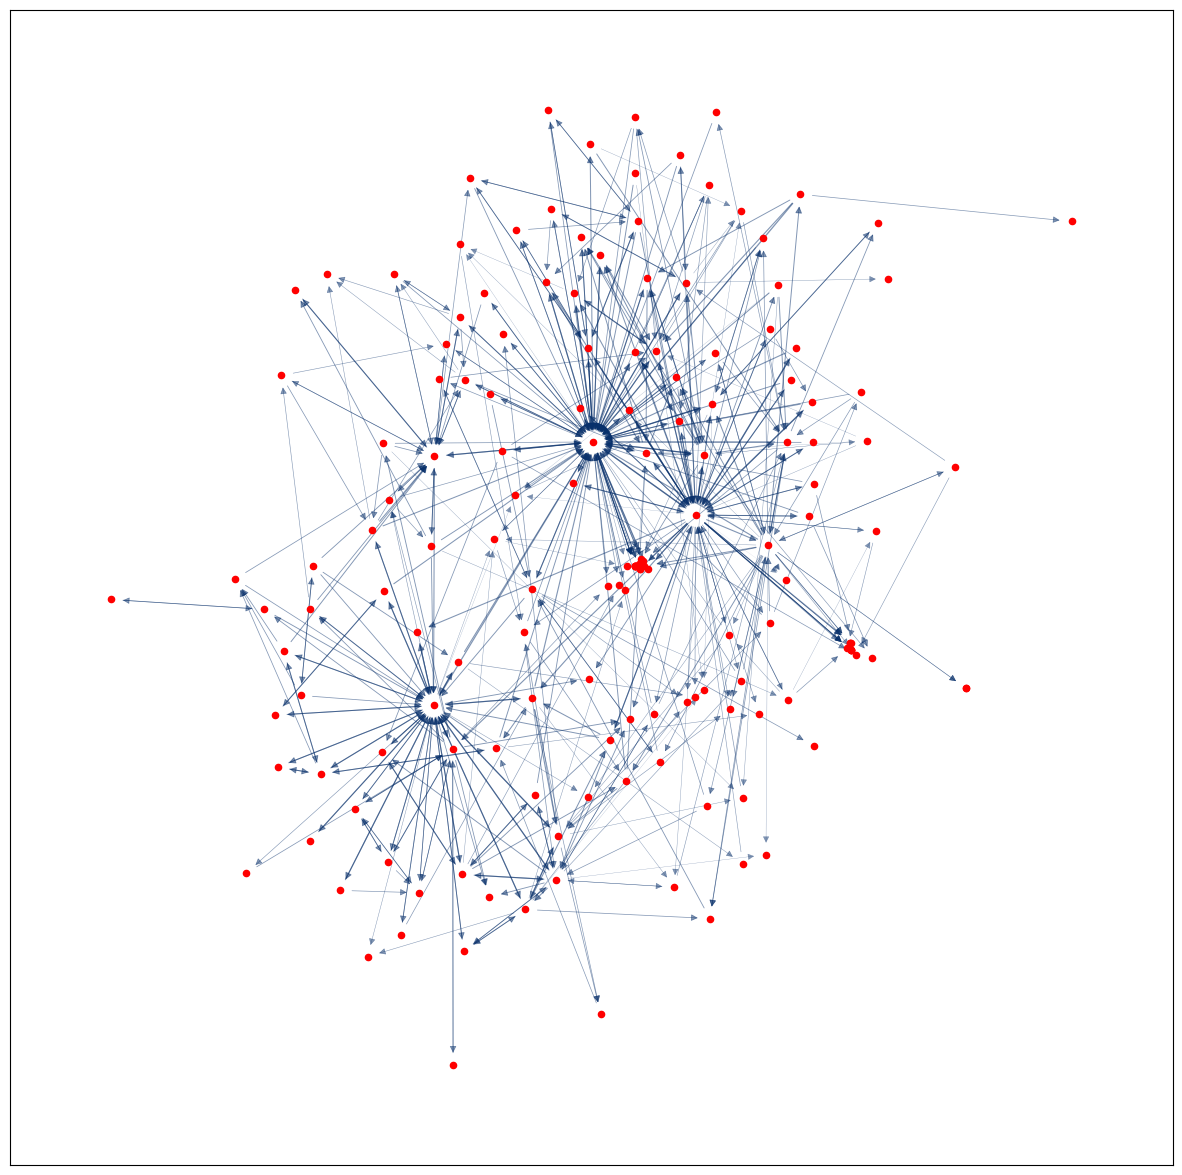

In [5]:
prices = nx.get_edge_attributes(G2018bin, 'price').values()
prices = [math.log(i) for i in list(prices)]
max_price = max(prices)
min_price = min(prices)
norm_prices = [(price - min_price) / (max_price - min_price) for price in prices]

edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=20, node_color='red', label=True)
#nx.draw_networkx_edges(G2018lite, pos, alpha=0.5)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)

plt.savefig("network.png")
plt.show()

In [6]:
G2018.edges.data('price')

OutEdgeDataView([('AGO', 'ALB', 55.16), ('AGO', 'ARE', 404671.528), ('AGO', 'ARG', 52638.04), ('AGO', 'ARM', 53.561), ('AGO', 'ATG', 417.007), ('AGO', 'AUS', 6182.212), ('AGO', 'AUT', 20898.467), ('AGO', 'AZE', 131.941), ('AGO', 'BDI', 29.141), ('AGO', 'BEL', 1006740.604), ('AGO', 'BEN', 506.068), ('AGO', 'BFA', 11.073), ('AGO', 'BGD', 1121.81), ('AGO', 'BGR', 2827.989), ('AGO', 'BHR', 1014.013), ('AGO', 'BHS', 66315.522), ('AGO', 'BIH', 548.942), ('AGO', 'BLR', 92642.254), ('AGO', 'BOL', 112.406), ('AGO', 'BRA', 765382.123), ('AGO', 'BRB', 0.474), ('AGO', 'BRN', 8.505), ('AGO', 'BTN', 20.85), ('AGO', 'BWA', 1398.744), ('AGO', 'CAF', 0.008), ('AGO', 'CAN', 87438.756), ('AGO', 'CHE', 30728.587), ('AGO', 'CHL', 7316.991), ('AGO', 'CHN', 2298744.694), ('AGO', 'CIV', 10142.443), ('AGO', 'CMR', 354.371), ('AGO', 'COG', 2989.735), ('AGO', 'COL', 1160.154), ('AGO', 'CRI', 792.282), ('AGO', 'CYP', 1279.623), ('AGO', 'CZE', 3659.351), ('AGO', 'DEU', 178937.246), ('AGO', 'DMA', 6.203), ('AGO', '

## Df creation

In [9]:
gdp_df = pd.read_csv('datasets/GDP.csv')
gdp2018 = gdp_df[gdp_df['Year']==2018][['Code', 'GDP (constant 2015 US$)']]

node_in =  pd.DataFrame.from_dict(dict(G2018.in_degree()),orient="index", columns=['Imp Deg']).reset_index()
node_out =  pd.DataFrame.from_dict(dict(G2018.out_degree()),orient="index", columns=['Exp Deg']).reset_index()
df_2018 = pd.merge(node_in, node_out, on='index')
df_2018 = df_2018.sort_values(by='index')
df_2018.reset_index(drop=True, inplace=True)
df_2018['Tot Deg'] = df_2018['Imp Deg'] + df_2018['Exp Deg']
df_2018['Import'] = Tot2018['Imp']
df_2018['Export'] = Tot2018['Exp']
df_2018['Tot Partners'] = [find_neighbors(G2018, i) for i in df_2018['index']]
df_2018['GDP'] = [np.NaN for _ in range(len(df_2018))]
for id in df_2018['index']:
    try:
        df_2018.loc[df_2018['index'] == id, 'GDP'] = gdp2018.loc[gdp2018['Code'] == id, 'GDP (constant 2015 US$)'].iloc[0]
    except:
        continue


df_2018

index  Imp Deg  Exp Deg  Tot Deg        Import        Export  \
0     AGO      102      149      251  1.624166e+07  4.339509e+07   
1     ALB      102      151      253  5.471018e+06  2.631311e+06   
2     ARE      115      159      274  2.131390e+08  1.862751e+08   
3     ARG      114      152      266  6.422755e+07  5.709266e+07   
4     ARM       96      140      236  4.692453e+06  1.916691e+06   
..    ...      ...      ...      ...           ...           ...   
156   VNM      115       92      207  2.202095e+08  2.911465e+08   
157   YEM       95        0       95  0.000000e+00  1.446759e+06   
158   ZAF      115      160      275  8.938826e+07  9.683663e+07   
159   ZMB      102      143      245  7.924597e+06  7.276179e+06   
160   ZWE      108      131      239  6.210250e+06  2.438711e+06   

     Tot Partners           GDP  
0             150  8.687296e+10  
1             151  1.270250e+10  
2             160  3.989149e+11  
3             155  5.831181e+11  
4             141  1.195864e+10  
..            ...           ...  
156           125  2.933586e+11  
157            95  3.678914e+10  
158           160  3.585516e+11  
159           149  2.374759e+10  
160           141  2.201518e+10  

[161 rows x 8 columns]

In [10]:
param = 'Import' # Choose between the df columns

percentile_99 = np.percentile(df_2018[param], 98)
hub_nodi = df_2018[df_2018[param] >= percentile_99]['index'].tolist()
print('Nodes hub 2018: ', hub_nodi)

Nodes hub 2018:  ['CHN', 'DEU', 'JPN', 'USA']


# Analysis on the binary graph

## Density

In [11]:
density = round(nx.density(G2018bin),3)
densityTot = round(nx.density(G2018),3)
print('2018 | Total density: {} | over 10%: {}'.format(densityTot, density))

2018 | Total density: 0.661 | over 10%: 0.021


## Degree

Standard deviation: 12.931313053869362
Mean: 6.795031055900621
Median: 4.0
Min: 1
Max: 125
Assortativity coefficient: -0.3430086707049379


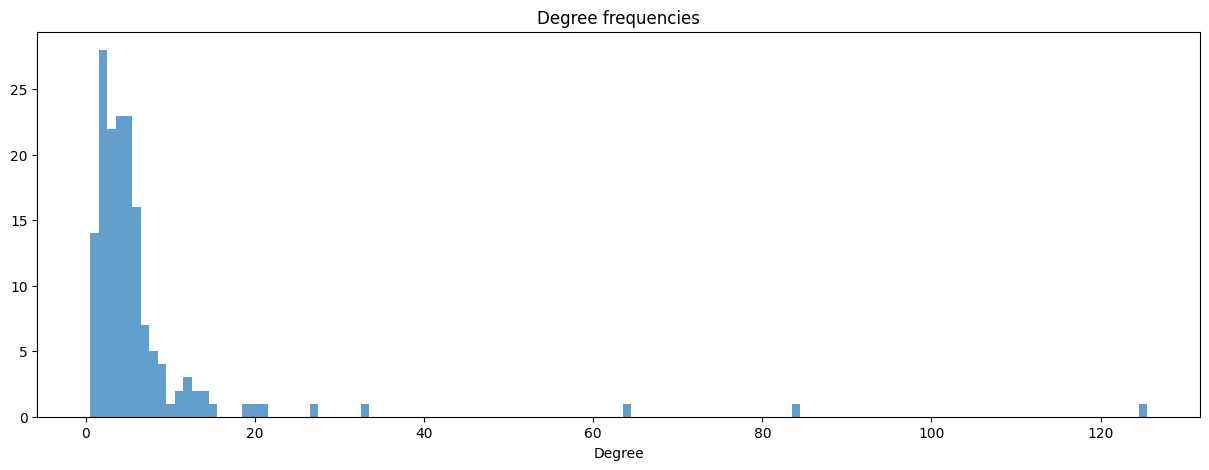

In [12]:
degree = list(dict(G2018bin.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2018bin)))

plt.figure(figsize=(15,5))
plt.hist(degree, bins=np.arange(min(degree), max(degree) + 2) - 0.5, alpha=0.7)
plt.xlabel('Degree')
plt.title('Degree frequencies')
plt.savefig('DegreeFreq2018')
plt.show()


In [13]:
print(dict(G2018bin.degree()))

{'AGO': 5, 'CHN': 125, 'PRT': 6, 'SGP': 14, 'TGO': 3, 'ALB': 2, 'ITA': 19, 'ARE': 15, 'BHR': 3, 'BWA': 4, 'COG': 2, 'IND': 33, 'LBN': 2, 'ARG': 9, 'BOL': 5, 'BRA': 12, 'PRY': 6, 'USA': 84, 'ARM': 5, 'RUS': 27, 'ATG': 2, 'AUS': 9, 'FJI': 6, 'NZL': 7, 'TON': 4, 'AUT': 3, 'BIH': 8, 'DEU': 64, 'AZE': 5, 'BMU': 4, 'TUR': 8, 'BDI': 6, 'SAU': 12, 'BEL': 13, 'DMA': 3, 'IRL': 6, 'LSO': 3, 'LUX': 6, 'MWI': 2, 'NLD': 13, 'SLE': 2, 'BEN': 4, 'THA': 11, 'BFA': 7, 'CIV': 7, 'MLI': 2, 'BGR': 5, 'GEO': 5, 'HRV': 8, 'BLR': 3, 'URY': 5, 'BRB': 4, 'TTO': 3, 'BRN': 5, 'MYS': 8, 'ZAF': 11, 'CAN': 3, 'CHE': 3, 'CHL': 4, 'CAF': 1, 'CMR': 2, 'COL': 4, 'ERI': 2, 'ETH': 2, 'GAB': 1, 'GHA': 3, 'GIN': 1, 'GMB': 4, 'GNQ': 1, 'IDN': 5, 'IRN': 2, 'JPN': 20, 'KAZ': 8, 'KOR': 14, 'KWT': 5, 'LAO': 5, 'MNG': 3, 'MRT': 2, 'NER': 2, 'OMN': 3, 'PER': 4, 'PHL': 7, 'PNG': 2, 'QAT': 6, 'TKM': 1, 'TZA': 5, 'UZB': 9, 'VEN': 3, 'VNM': 6, 'YEM': 2, 'ZMB': 3, 'ZWE': 4, 'FRA': 21, 'NGA': 6, 'CRI': 3, 'CYP': 2, 'GRC': 4, 'CZE': 5, '

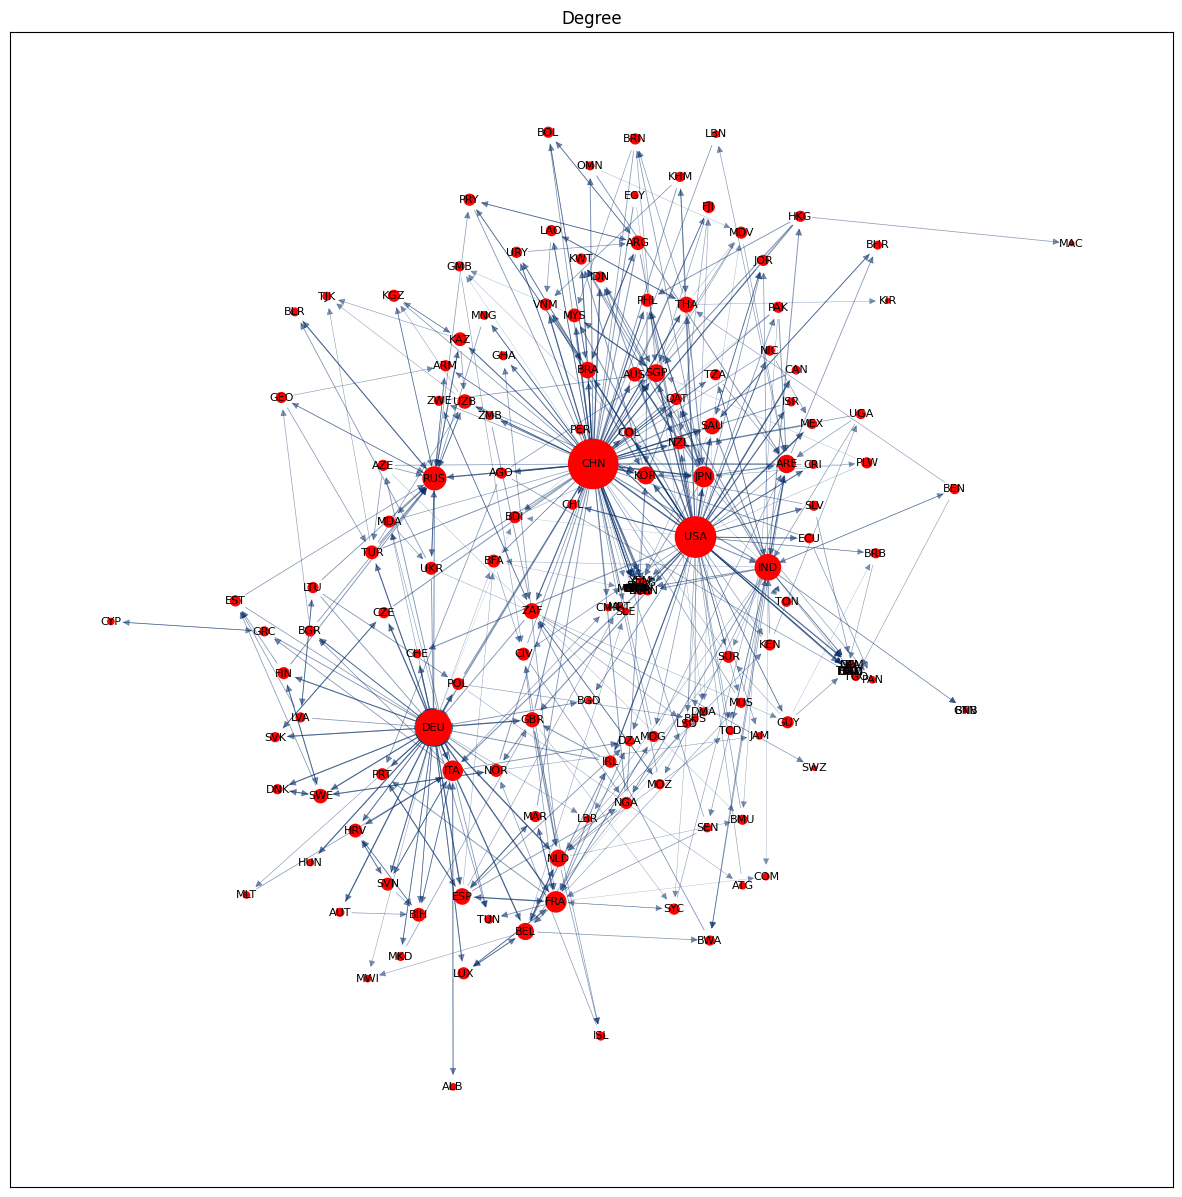

In [14]:
edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [v*10 for v in degree]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=node_size, node_color='red', label=True)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)

plt.title('Degree')

plt.savefig("Degree.png")
plt.show()

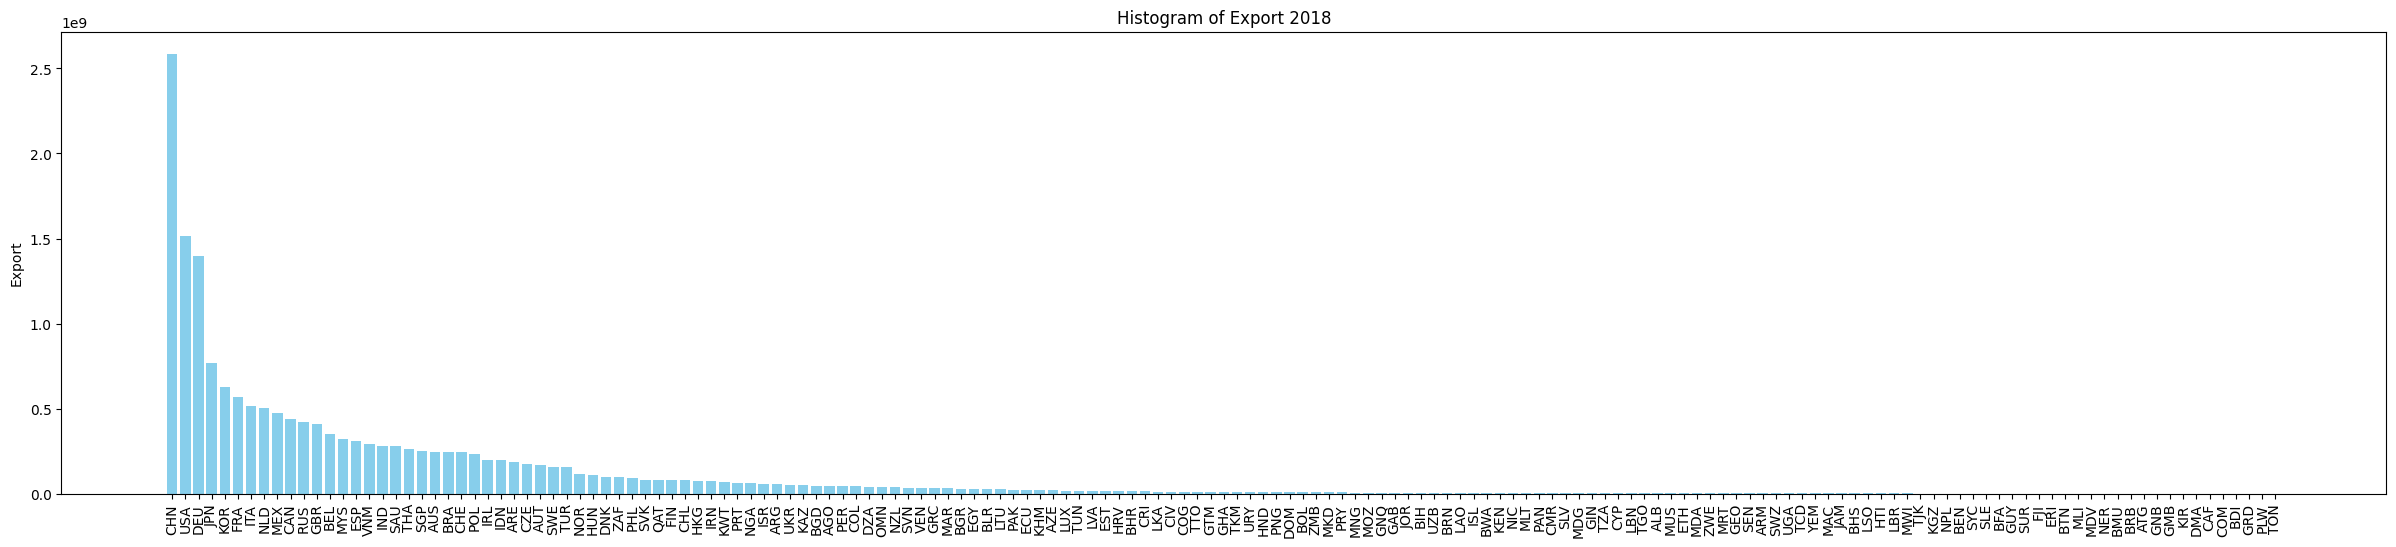

In [15]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2018.sort_values(by=plot, ascending=False)['index'], df_2018.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2018')
plt.xticks(rotation=90)
plt.savefig(plot+"2018.png")
plt.show()


In [16]:
print(list(nx.isolates(G2018)))

[]


## Clustering

In [17]:
clusters = nx.average_clustering(G2018bin, weight='wheight') #weight='price'
clusters

0.4235562717428934

In [18]:
local_cluster = nx.clustering(G2018bin, weight='weight')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('AUT', 1.0),
 ('MWI', 1.0),
 ('MLI', 1.0),
 ('BLR', 1.0),
 ('CAN', 1.0),
 ('CHL', 1.0),
 ('COL', 1.0),
 ('ERI', 1.0),
 ('ETH', 1.0),
 ('MNG', 1.0),
 ('NER', 1.0),
 ('PER', 1.0),
 ('PNG', 1.0),
 ('YEM', 1.0),
 ('ZMB', 1.0),
 ('CRI', 1.0),
 ('SVK', 1.0),
 ('DNK', 1.0),
 ('MKD', 1.0),
 ('MLT', 1.0),
 ('SVN', 1.0),
 ('ISR', 1.0),
 ('GTM', 1.0),
 ('KGZ', 0.9230769230769231),
 ('HRV', 0.9166666666666666),
 ('MEX', 0.9),
 ('NIC', 0.9),
 ('IDN', 0.8888888888888888),
 ('BOL', 0.875),
 ('URY', 0.875),
 ('LUX', 0.8333333333333334),
 ('TTO', 0.8333333333333334),
 ('BIH', 0.8),
 ('NZL', 0.7777777777777778),
 ('ARM', 0.75),
 ('LAO', 0.75),
 ('FJI', 0.7142857142857143),
 ('QAT', 0.7142857142857143),
 ('BRB', 0.7),
 ('PHL', 0.6842105263157895),
 ('VEN', 0.6666666666666666),
 ('TUN', 0.6666666666666666),
 ('JOR', 0.6666666666666666),
 ('KHM', 0.6666666666666666),
 ('TZA', 0.625),
 ('CZE', 0.625),
 ('KAZ', 0.62),
 ('PRT', 0.6153846153846154),
 ('PRY', 0.6153846153846154),
 ('KWT', 0.6111111111111112),

## Centrality

In [19]:
import statistics
deg_centr = nx.degree_centrality(G2018bin)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 0.04246894409937888
median of degree centrality: 0.025
min of degree centrality: ('SWZ', 0.00625)
max of degree centrality: ('CHN', 0.78125)
10 most important nodes for Degree Centrality:
('CHN', 0.78125)
('USA', 0.525)
('DEU', 0.4)
('IND', 0.20625000000000002)
('RUS', 0.16875)
('FRA', 0.13125)
('JPN', 0.125)
('ITA', 0.11875000000000001)
('ARE', 0.09375)
('SGP', 0.08750000000000001)


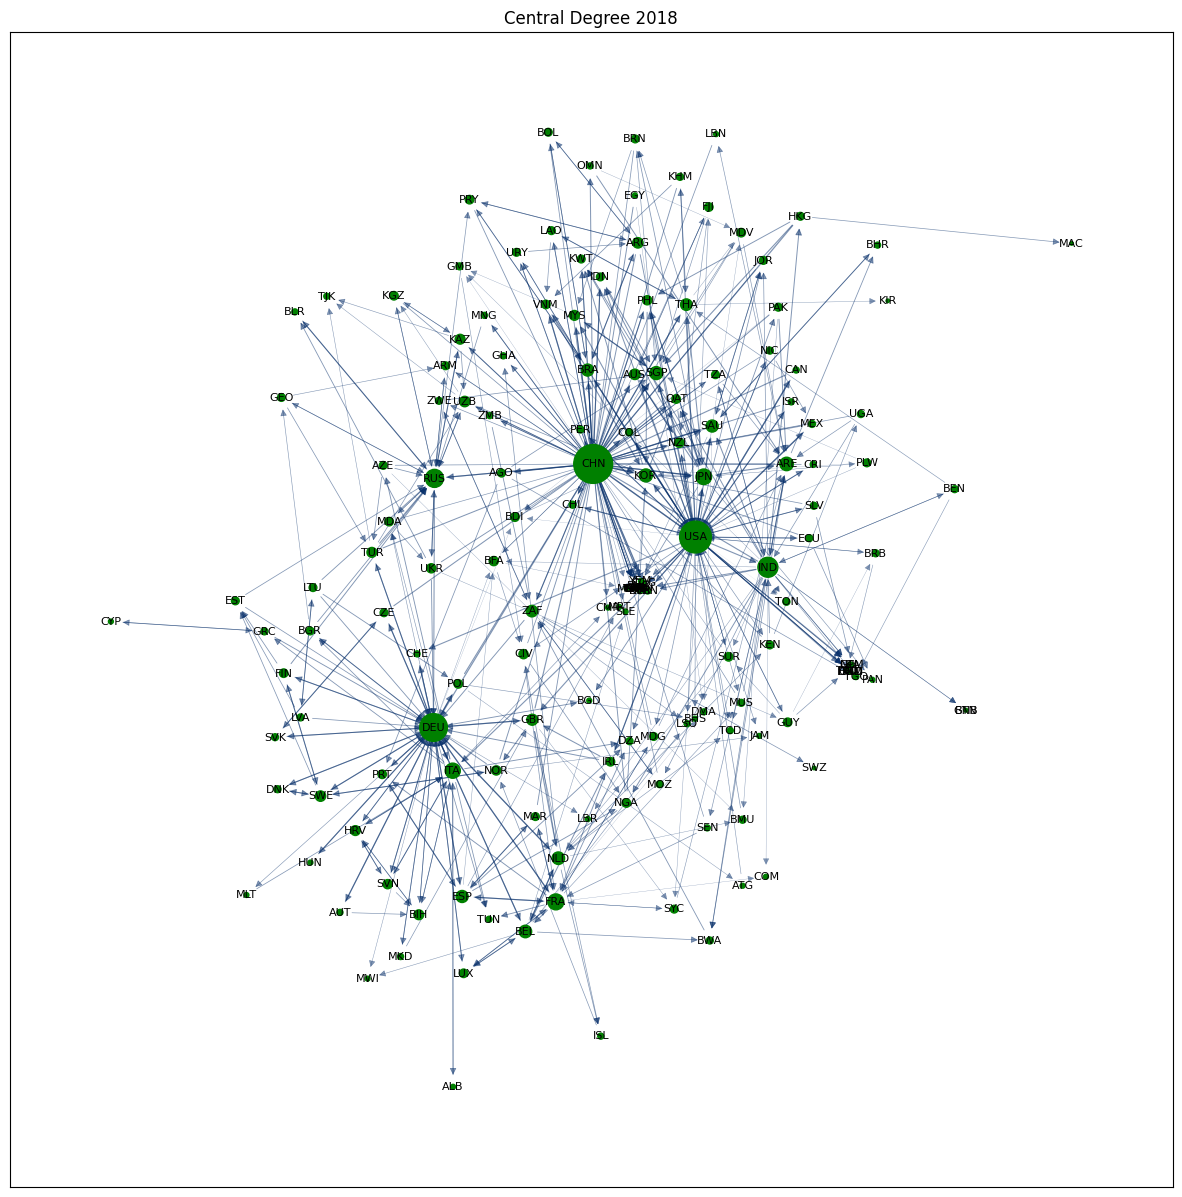

In [20]:
edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [deg_centr[i]*1000 for i in deg_centr]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=node_size, node_color='green', label=True)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)

plt.title('Central Degree 2018')

plt.savefig("CentralDegree2018.png")
plt.show()

## Betweeness

In [21]:
betweenesCentrality = nx.betweenness_centrality(G2018bin, weight='weight')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.008231522715731084
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('CHN', 0.4017413023868524)
('CHN', 0.4017413023868524)
('USA', 0.2287491967583533)
('DEU', 0.2001957214243909)
('RUS', 0.05623347117797729)
('IND', 0.04606728930136951)
('ITA', 0.043193576165274285)
('ZAF', 0.03468226998471173)
('FRA', 0.0238794414635494)
('JPN', 0.019969200587610675)
('SAU', 0.017127460022507195)


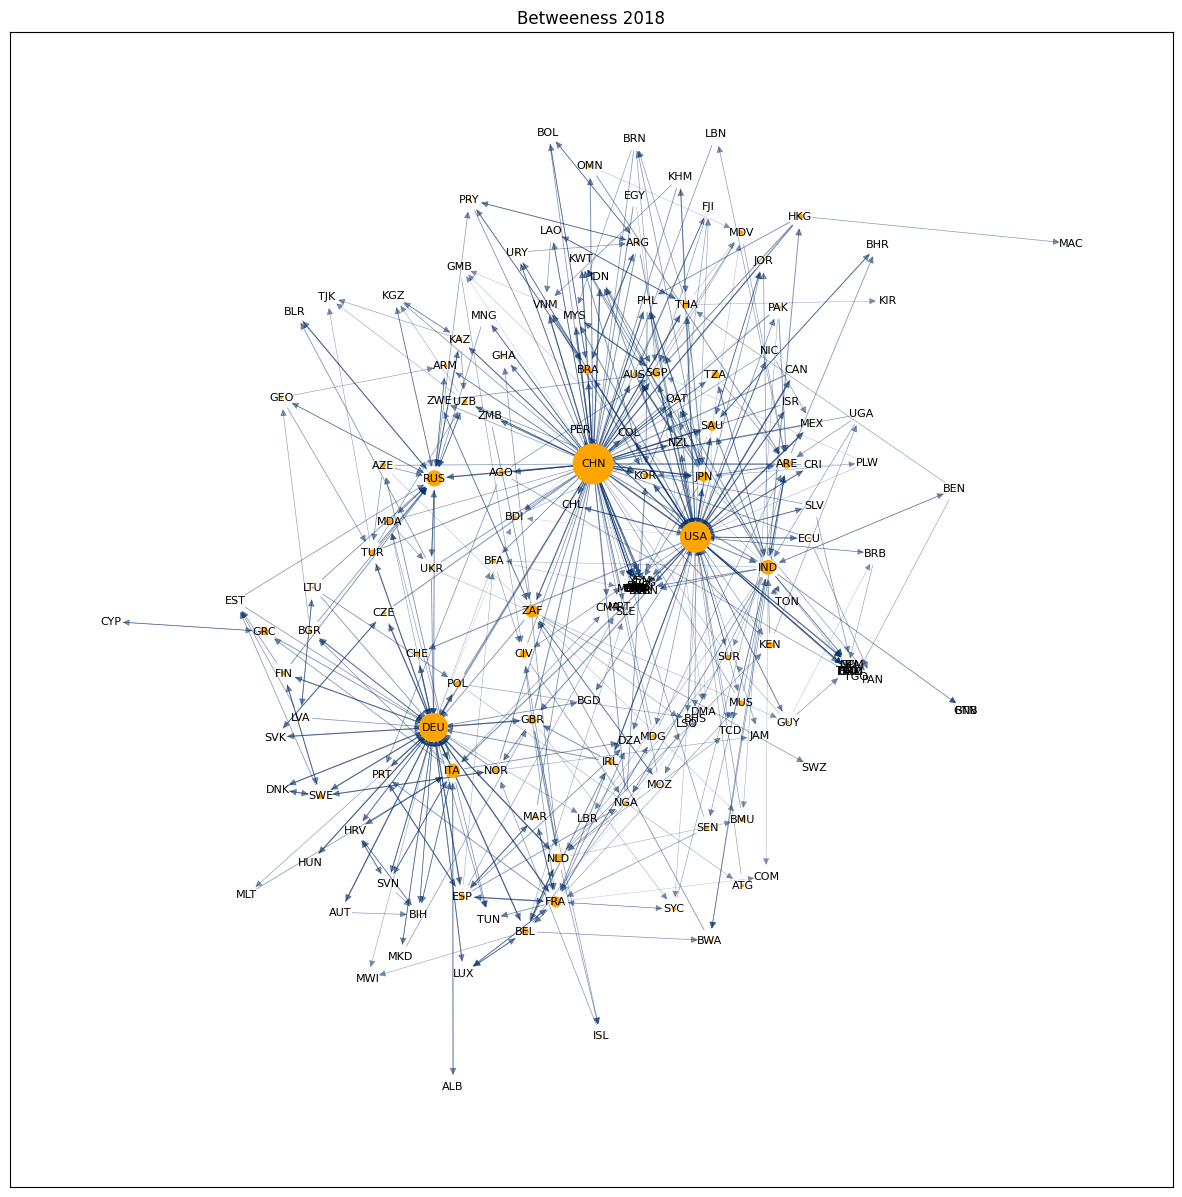

In [22]:
edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [betweenesCentrality[i]*2018 for i in betweenesCentrality]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=node_size, node_color='orange', label=True)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)
plt.title('Betweeness 2018')

plt.savefig("betweeness2018.png")
plt.show()

## Eigenvector

In [23]:
eigen = nx.eigenvector_centrality(G2018bin, weight='weight')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.05269220940486859
max of eigenvector centrality: ('CHN', 0.571992170571129)
10 most important nodes for Eigenvector Centrality:
('CHN', 0.571992170571129)
('USA', 0.2809347585819496)
('SGP', 0.1669146115807082)
('JPN', 0.14904284917622002)
('KOR', 0.14502787327341807)
('RUS', 0.12990552299164346)
('MYS', 0.12516852313127338)
('BRA', 0.12111429586528875)
('PHL', 0.12013168582046094)
('NZL', 0.11958284901602426)


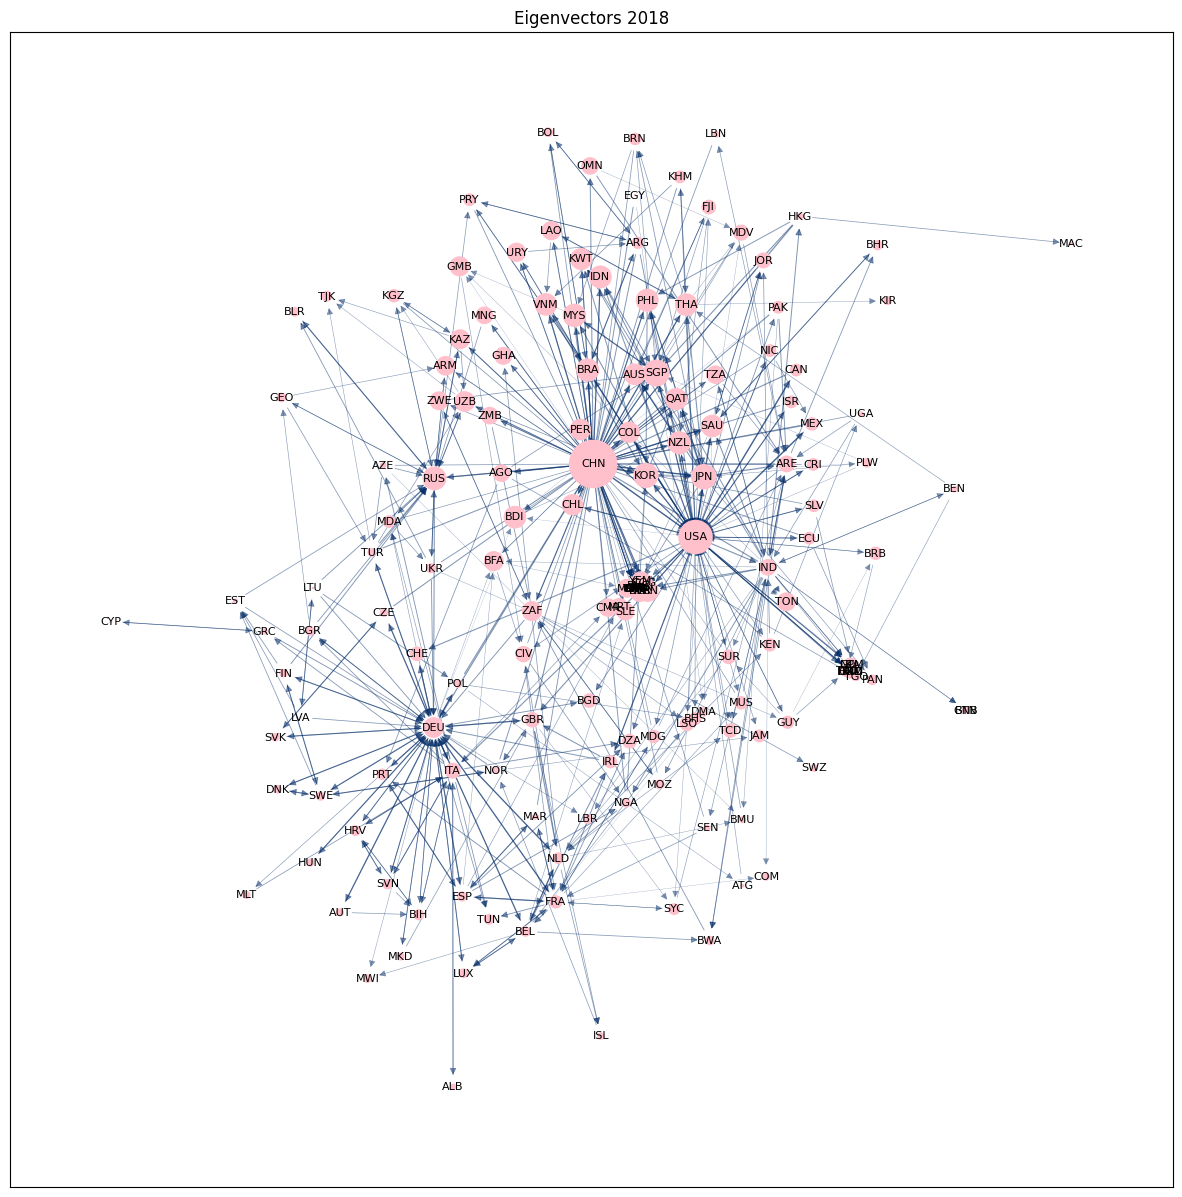

In [24]:
edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [eigen[i]*2018 for i in eigen]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=node_size, node_color='pink', label=True)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)
plt.title('Eigenvectors 2018')

plt.savefig("Eigenvector2018.png")
plt.show()

## Pagerank

In [25]:
pagerank = nx.pagerank(G2018bin, alpha=0.85, weight='weight')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.0062111801242235995
max of pagerank: ('CHN', 0.1121494449691726)
10 most important nodes for Page Rank:
('CHN', 0.1121494449691726)
('DEU', 0.0476765459355247)
('USA', 0.04222507465159006)
('RUS', 0.027455890786518805)
('SGP', 0.015706690087799423)
('ITA', 0.014055788449585003)
('SAU', 0.013652789205844484)
('FRA', 0.01343710951820131)
('ZAF', 0.012931796530231472)
('KOR', 0.012040082700826689)


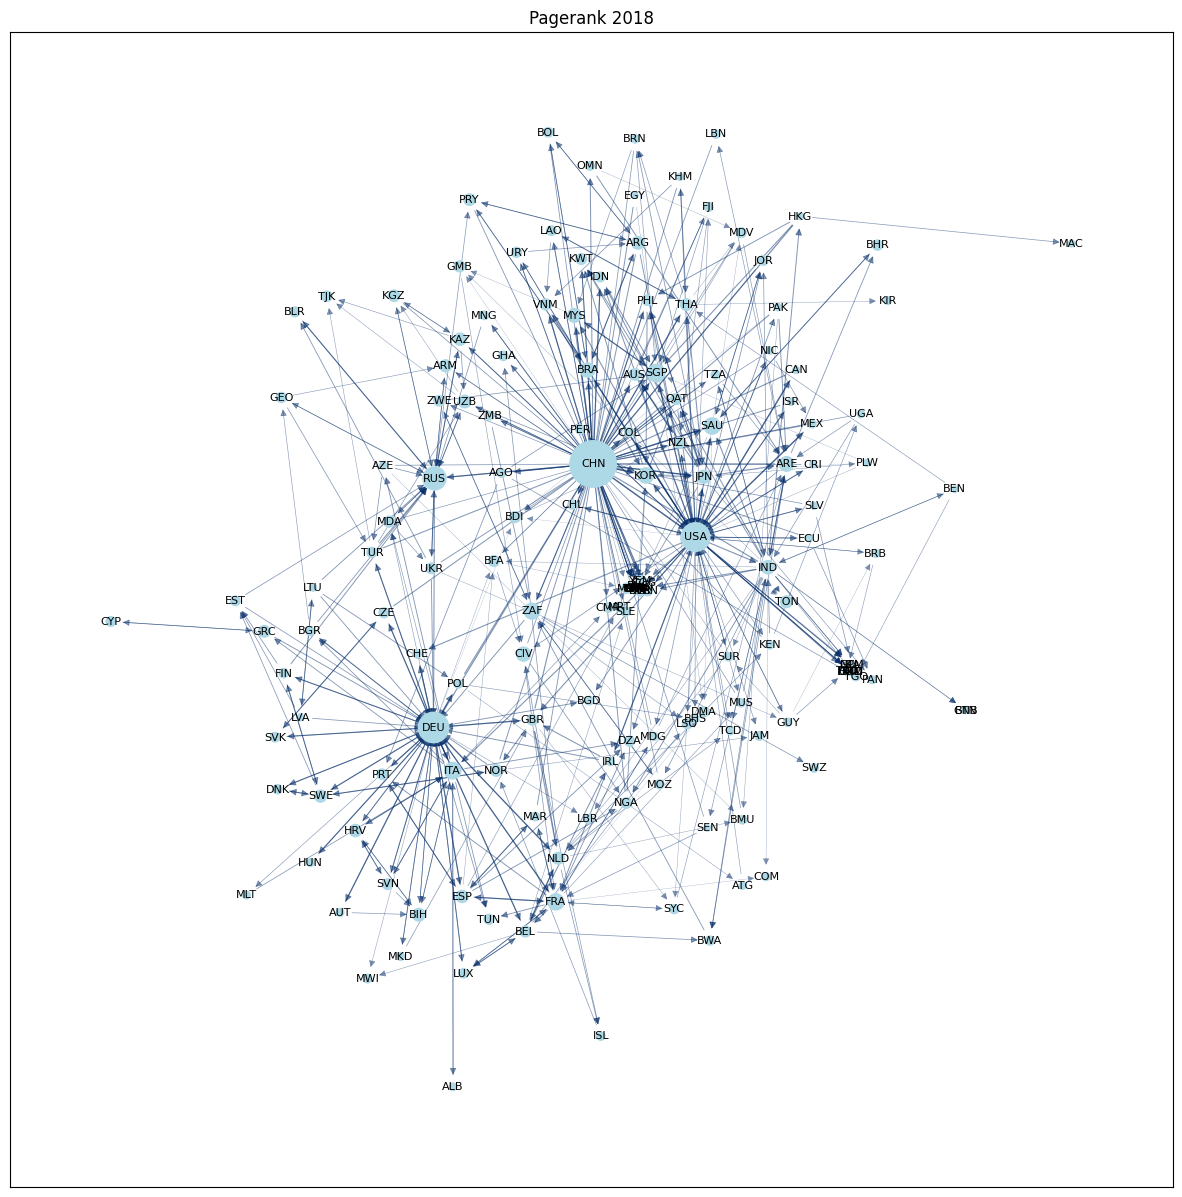

In [26]:
edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [pagerank[i]*10000 for i in pagerank]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=node_size, node_color='lightblue', label=True)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)
plt.title('Pagerank 2018')

plt.savefig("Pagerank2018.png")
plt.show()

## Closeness

In [27]:
closeness = nx.closeness_centrality(G2018bin)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.2561523455498331
10 most important nodes for closeness_centrality:
('CHN', 0.5166015625)
('USA', 0.3472951680672269)
('BDI', 0.345842050209205)
('BFA', 0.3401491769547325)
('RUS', 0.33329133064516125)
('SGP', 0.3228759765625)
('DEU', 0.3216196498054475)
('KOR', 0.31669061302681994)
('JPN', 0.31548187022900764)
('CMR', 0.31498127340823967)


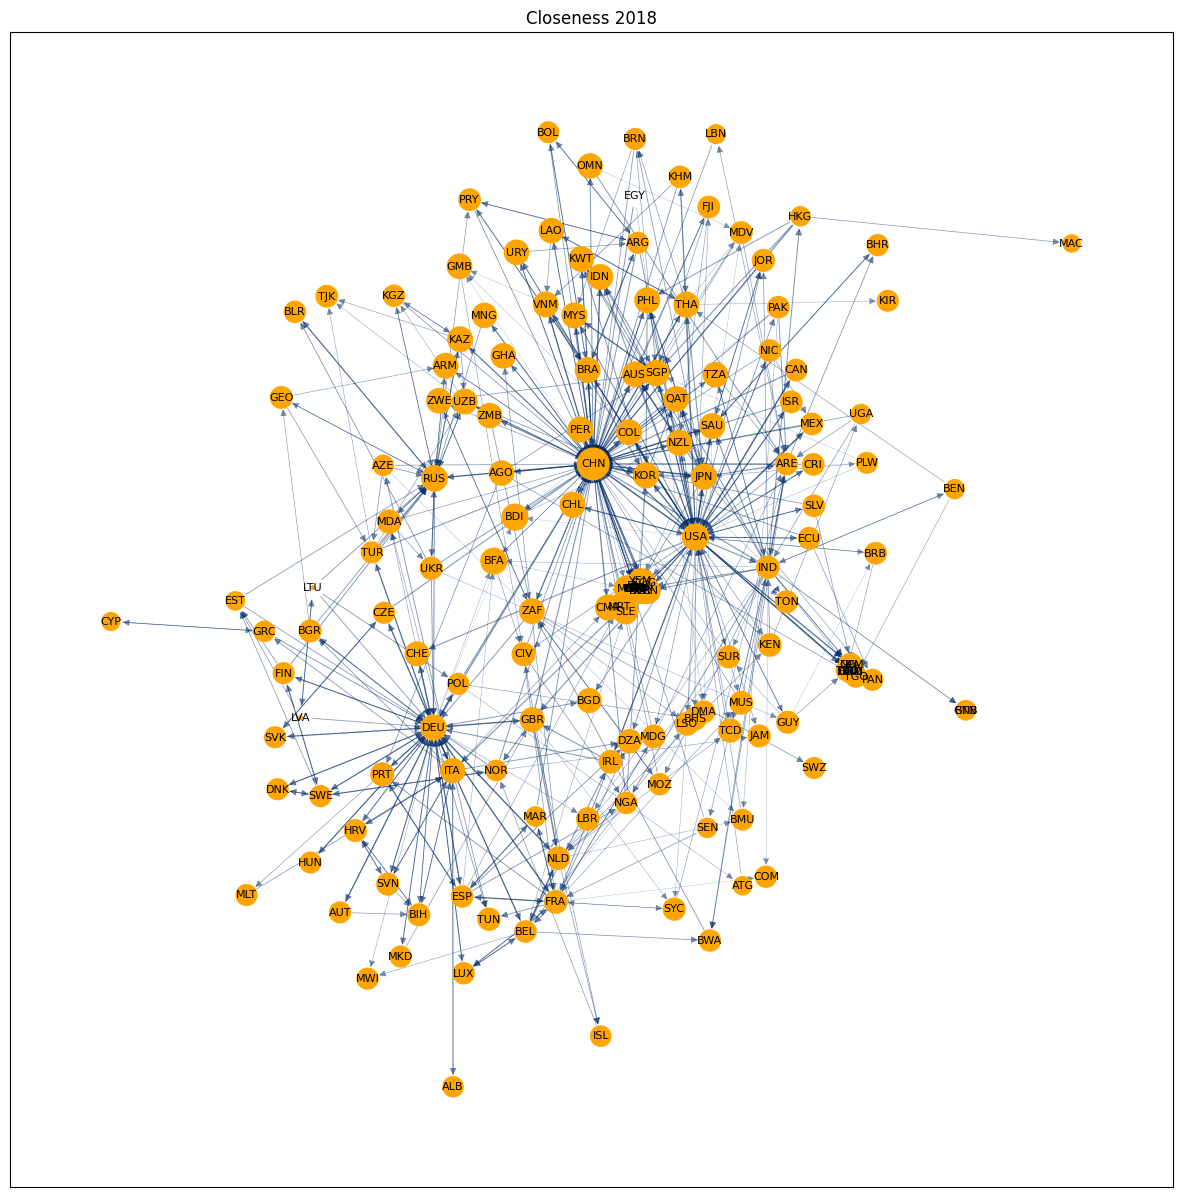

In [28]:
edges = G2018bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [closeness[i]*1000 for i in closeness]

# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2018bin, pos, node_size=node_size, node_color='orange', label=True)
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)
plt.title('Closeness 2018')

plt.savefig("closeness2018.png")
plt.show()

## Communities

In [29]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2018bin,weight='weight'))
print(list_community_sets_greedy[0:20])

[frozenset({'ITA', 'FRA', 'DZA', 'CZE', 'HRV', 'POL', 'FIN', 'BIH', 'PRT', 'ALB', 'LVA', 'SVN', 'MAR', 'LUX', 'CHE', 'GBR', 'SWE', 'BGR', 'TUN', 'DNK', 'LTU', 'GRC', 'SVK', 'AUT', 'NLD', 'IRL', 'DEU', 'EST', 'ISL', 'MWI', 'MLT', 'SYC', 'HUN', 'ESP', 'CYP', 'MDG', 'NOR', 'BEL', 'MKD'}), frozenset({'MNG', 'CHL', 'SLE', 'PNG', 'ERI', 'GAB', 'KWT', 'ZWE', 'PRY', 'CMR', 'COL', 'ZMB', 'GHA', 'ZAF', 'KIR', 'PER', 'LSO', 'THA', 'MRT', 'AGO', 'URY', 'MOZ', 'BFA', 'MLI', 'ETH', 'TKM', 'GIN', 'ARG', 'GNQ', 'NER', 'BRA', 'LAO', 'BOL', 'KHM', 'CHN', 'SWZ', 'CAF', 'VNM'}), frozenset({'ATG', 'MAC', 'CAN', 'PHL', 'SGP', 'FJI', 'GRD', 'MEX', 'TON', 'HTI', 'DOM', 'NZL', 'PLW', 'GUY', 'TTO', 'PAN', 'BRB', 'BRN', 'JPN', 'SUR', 'HND', 'ECU', 'AUS', 'BHS', 'BGD', 'QAT', 'GTM', 'SLV', 'MYS', 'CRI', 'IDN', 'ISR', 'JAM', 'USA', 'NIC', 'HKG', 'KOR'}), frozenset({'YEM', 'IND', 'SAU', 'BMU', 'COM', 'BHR', 'NPL', 'LBN', 'LKA', 'ARE', 'BDI', 'TCD', 'BTN', 'TGO', 'TZA', 'LBR', 'EGY', 'BWA', 'KEN', 'BEN', 'VEN', 'PAK

In [30]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 39
Community: 1
Number of elems 38
Community: 2
Number of elems 37
Community: 3
Number of elems 32
Community: 4
Number of elems 12
Community: 5
Number of elems 3


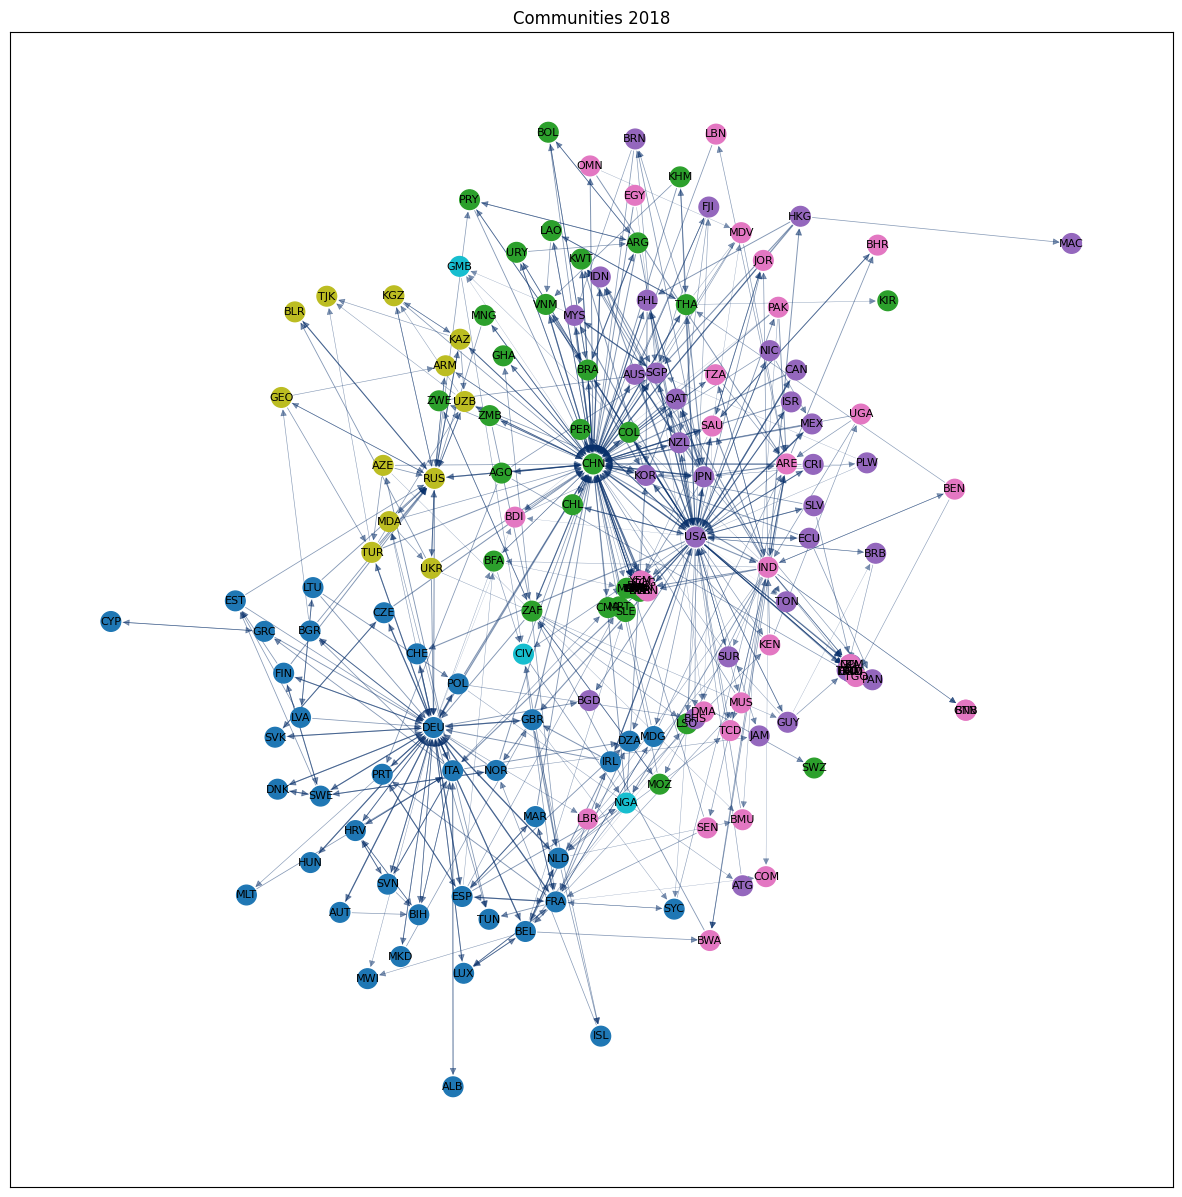

In [31]:
# draw the graph
pos = nx.kamada_kawai_layout(G2018bin)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2018bin, pos, partition_greedy.keys(), node_size=200,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2018bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2018bin, pos, font_size = 8)
plt.title('Communities 2018')
plt.savefig('Commmunity2018.png')


plt.show()

# Analysis on original graph

## Density

In [32]:
density = nx.density(G2018)
print('Density 2018: {}'.format(density))

Density 2018: 0.6611024844720497


## Degree

In [33]:
degree = list(dict(G2018.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2018)))

Standard deviation: 73.77773407324754
Mean: 211.5527950310559
Median: 250.0
Min: 52
Max: 275
Assortativity coefficient: -0.13587297932270792


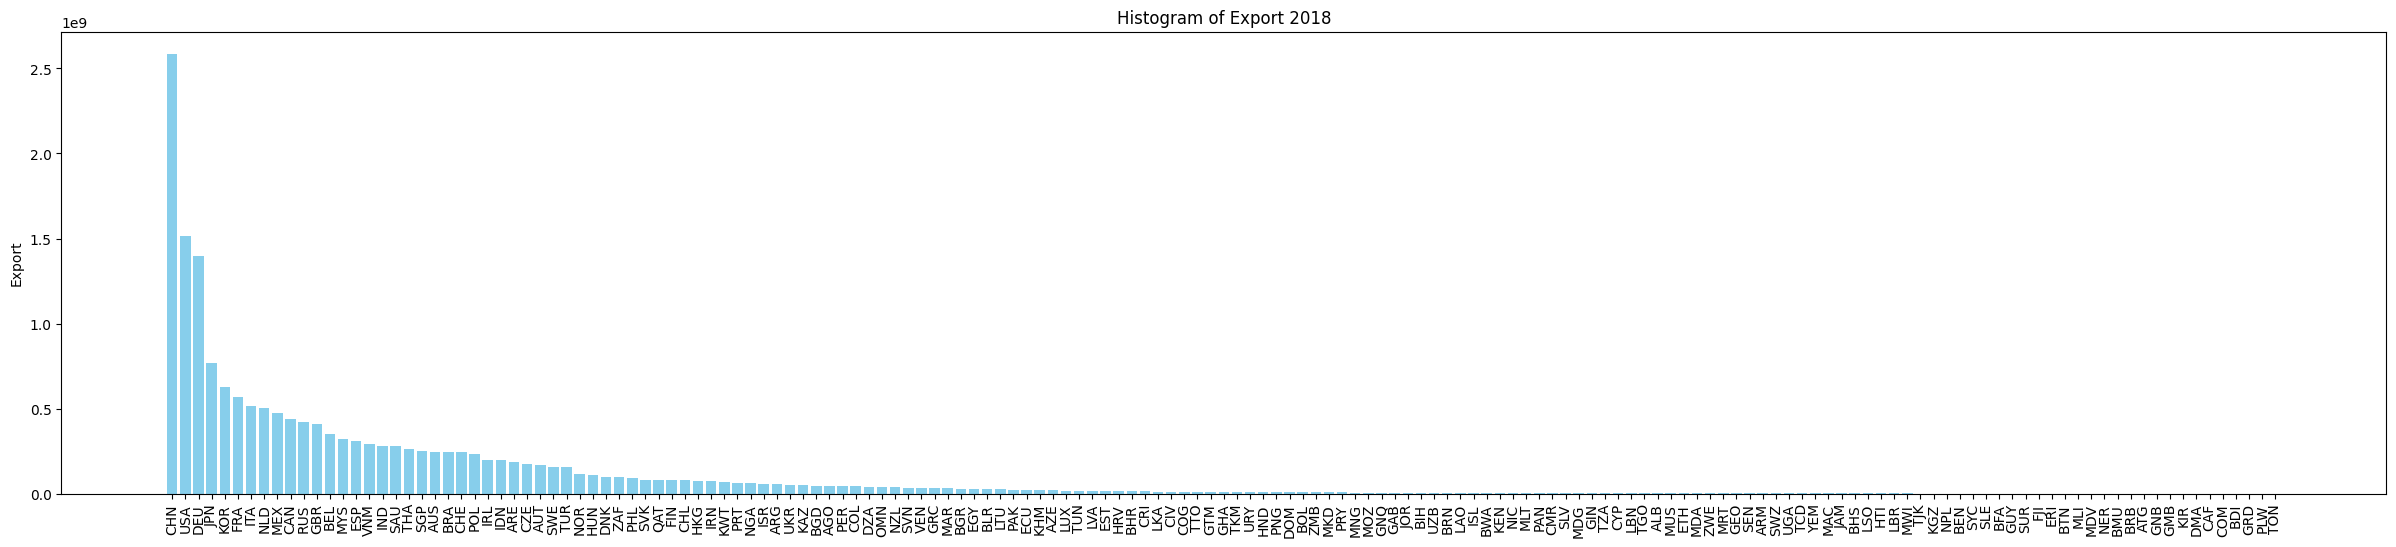

In [34]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2018.sort_values(by=plot, ascending=False)['index'], df_2018.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2018')
plt.xticks(rotation=90)
plt.savefig(plot+"2018.png")
plt.show()


In [35]:
print(list(nx.isolates(G2018)))

[]


## Clustering

In [36]:
clusters = nx.average_clustering(G2018) #weight='price'
clusters

0.8505366408007888

In [37]:
local_cluster = nx.clustering(G2018, weight='price')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('CHN', 0.0035722391693716144),
 ('USA', 0.0032099849003878194),
 ('DEU', 0.002730291294549307),
 ('JPN', 0.0016889436444133407),
 ('FRA', 0.0016363221969931728),
 ('GBR', 0.001478461162102685),
 ('ITA', 0.0014768592537547601),
 ('KOR', 0.0013805470429474685),
 ('NLD', 0.0013676833848011872),
 ('VNM', 0.0013613703399617933),
 ('BEL', 0.0011552107756471154),
 ('IND', 0.001146960483371355),
 ('ESP', 0.0010999599325720343),
 ('RUS', 0.0010508530477172451),
 ('CAN', 0.0008648159143186187),
 ('MEX', 0.0008416535074062949),
 ('POL', 0.0008391788523416052),
 ('SGP', 0.000828895417496049),
 ('THA', 0.0008066056995248695),
 ('CHE', 0.0007966754337539389),
 ('MYS', 0.0007780006681576984),
 ('TUR', 0.0007490535102863136),
 ('BRA', 0.0007451746945395778),
 ('AUS', 0.0006810630046763222),
 ('ARE', 0.0006798729718664459),
 ('SAU', 0.0006793704970091228),
 ('HKG', 0.0006697684804962128),
 ('IDN', 0.0006660891821610547),
 ('SWE', 0.0006305177950818109),
 ('AUT', 0.0006265103382246345),
 ('CZE', 0.000

## Centrality

In [38]:
import statistics
deg_centr = nx.degree_centrality(G2018)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 1.3222049689440993
median of degree centrality: 1.5625
min of degree centrality: ('KIR', 0.325)
max of degree centrality: ('AUS', 1.71875)
10 most important nodes for Degree Centrality:
('AUS', 1.71875)
('BEL', 1.71875)
('BRA', 1.71875)
('CHE', 1.71875)
('CHN', 1.71875)
('CZE', 1.71875)
('DNK', 1.71875)
('ESP', 1.71875)
('FRA', 1.71875)
('GBR', 1.71875)


## Betweeness

In [39]:
betweenesCentrality = nx.betweenness_centrality(G2018, weight='price')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.016425080081253176
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('ZMB', 0.31678459119496855)
('ZMB', 0.31678459119496855)
('PLW', 0.2585888364779874)
('BRB', 0.17431210691823898)
('BMU', 0.16566430817610062)
('BRN', 0.14339622641509434)
('BWA', 0.1407625786163522)
('UZB', 0.10896226415094339)
('BFA', 0.09479166666666666)
('NIC', 0.08140723270440252)
('SLV', 0.07708333333333332)


## Eigenvector

In [40]:
eigen = nx.eigenvector_centrality(G2018, weight='price')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.02916227812317124
max of eigenvector centrality: ('CHN', 0.6032460634710778)
10 most important nodes for Eigenvector Centrality:
('CHN', 0.6032460634710778)
('USA', 0.3933952163085465)
('JPN', 0.29032878591058864)
('DEU', 0.2776616884452305)
('KOR', 0.2539417247764912)
('MEX', 0.21488982466867584)
('CAN', 0.2068244091645959)
('FRA', 0.1250428072530326)
('AUS', 0.11610841880340164)
('ITA', 0.11214961387270925)


## Pagerank

In [41]:
pagerank = nx.pagerank(G2018, alpha=0.85, weight='price')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.006211180124223604
max of pagerank: ('CHN', 0.10854868044293044)
10 most important nodes for Page Rank:
('CHN', 0.10854868044293044)
('USA', 0.0718053628131052)
('DEU', 0.06443661873488643)
('JPN', 0.036196142921742176)
('KOR', 0.030524443475889222)
('FRA', 0.027418093866483608)
('ITA', 0.025495950705169405)
('RUS', 0.024310386410715187)
('NLD', 0.023294034366999217)
('GBR', 0.020599022355770793)


## Closeness

In [42]:
closeness = nx.closeness_centrality(G2018)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.6709715941417322
10 most important nodes for closeness_centrality:
('BGD', 0.725)
('TUN', 0.725)
('LKA', 0.7188034188034188)
('ARE', 0.71875)
('AUS', 0.71875)
('AUT', 0.71875)
('BEL', 0.71875)
('BGR', 0.71875)
('BRA', 0.71875)
('CAN', 0.71875)


## Communities

In [43]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2018,weight='price'))
print(list_community_sets_greedy[0:20])

[frozenset({'MNG', 'CHL', 'ERI', 'IND', 'SAU', 'KWT', 'ZWE', 'COM', 'PRY', 'BHR', 'NPL', 'ARE', 'BDI', 'TON', 'BTN', 'ZMB', 'KIR', 'PER', 'NZL', 'PLW', 'AGO', 'TGO', 'URY', 'ETH', 'TZA', 'GIN', 'TKM', 'BWA', 'KEN', 'ARG', 'BEN', 'PAK', 'MDV', 'BRN', 'OMN', 'NER', 'BRA', 'NGA', 'GNB', 'QAT', 'MYS', 'CHN', 'CAF', 'VNM', 'KOR', 'YEM', 'MAC', 'SLE', 'PNG', 'PHL', 'GAB', 'SGP', 'FJI', 'GHA', 'ZAF', 'THA', 'MRT', 'MOZ', 'MLI', 'GNQ', 'JOR', 'IRN', 'JPN', 'AUS', 'LAO', 'COG', 'BOL', 'SYC', 'KHM', 'UGA', 'IDN', 'SWZ', 'MUS', 'HKG', 'MDG'}), frozenset({'ITA', 'GMB', 'FRA', 'UZB', 'MDA', 'TUR', 'AZE', 'DZA', 'CZE', 'HRV', 'CMR', 'LBN', 'FIN', 'POL', 'BIH', 'TJK', 'ALB', 'PRT', 'ARM', 'LVA', 'SVN', 'BLR', 'MAR', 'LUX', 'CHE', 'GBR', 'SWE', 'BGR', 'TUN', 'BFA', 'UKR', 'LBR', 'EGY', 'CIV', 'DNK', 'SEN', 'RUS', 'LTU', 'DMA', 'GRC', 'SVK', 'AUT', 'NLD', 'KAZ', 'BGD', 'EST', 'DEU', 'MLT', 'MWI', 'ISL', 'IRL', 'GEO', 'HUN', 'KGZ', 'ESP', 'CYP', 'NOR', 'BEL', 'MKD'}), frozenset({'ATG', 'CAN', 'VEN', 'BM

In [44]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 75
Community: 1
Number of elems 59
Community: 2
Number of elems 27


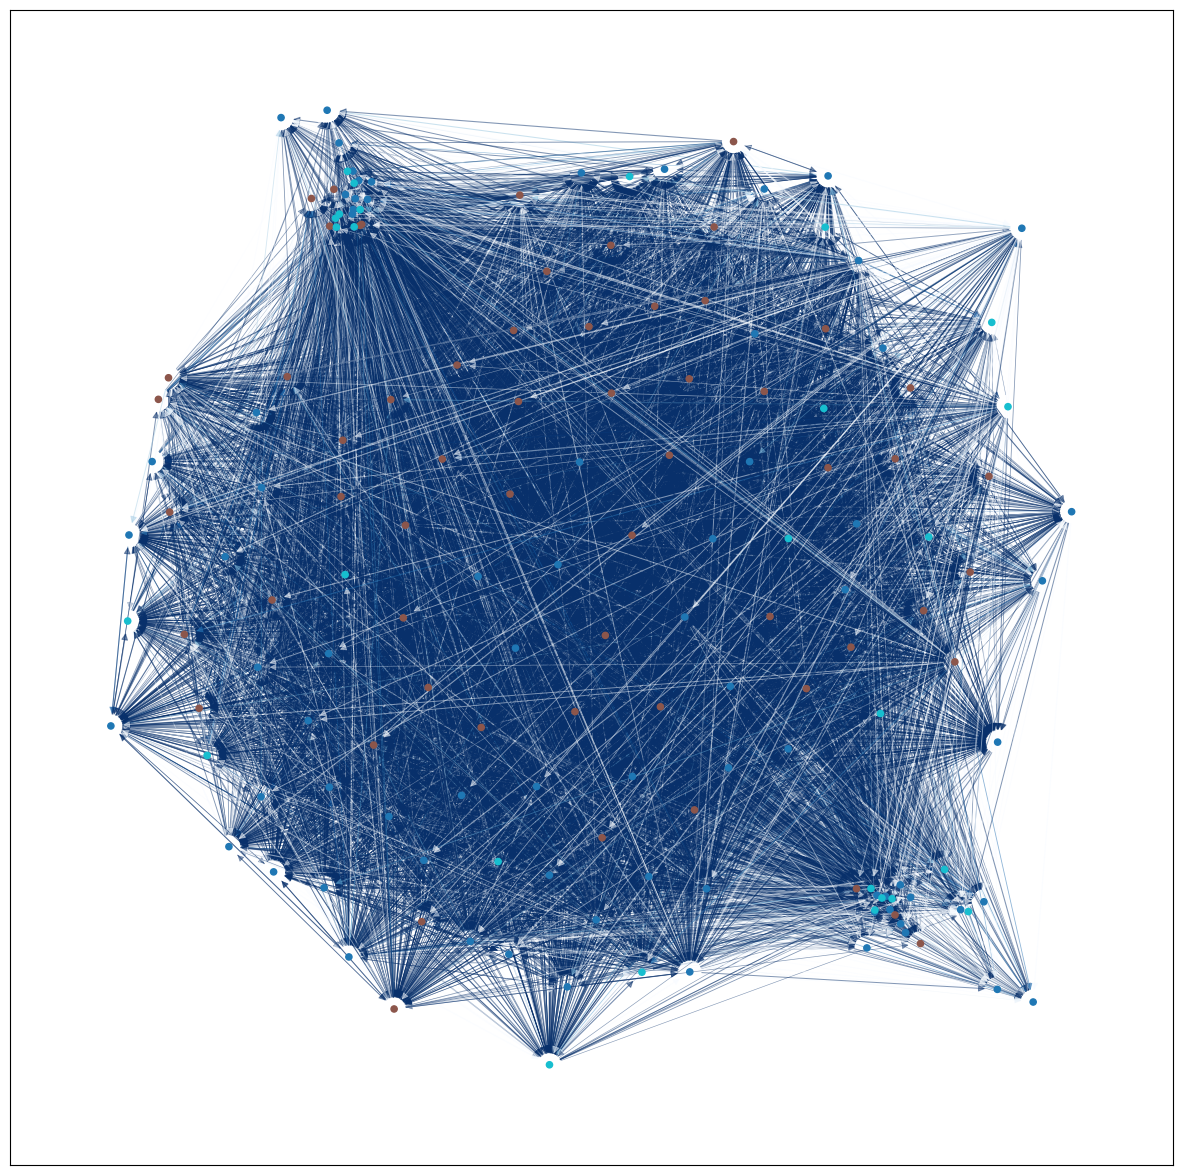

In [45]:
edges = G2018.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
# draw the graph
pos = nx.kamada_kawai_layout(G2018)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2018, pos, partition_greedy.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2018, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)


plt.show()

## Data correlations

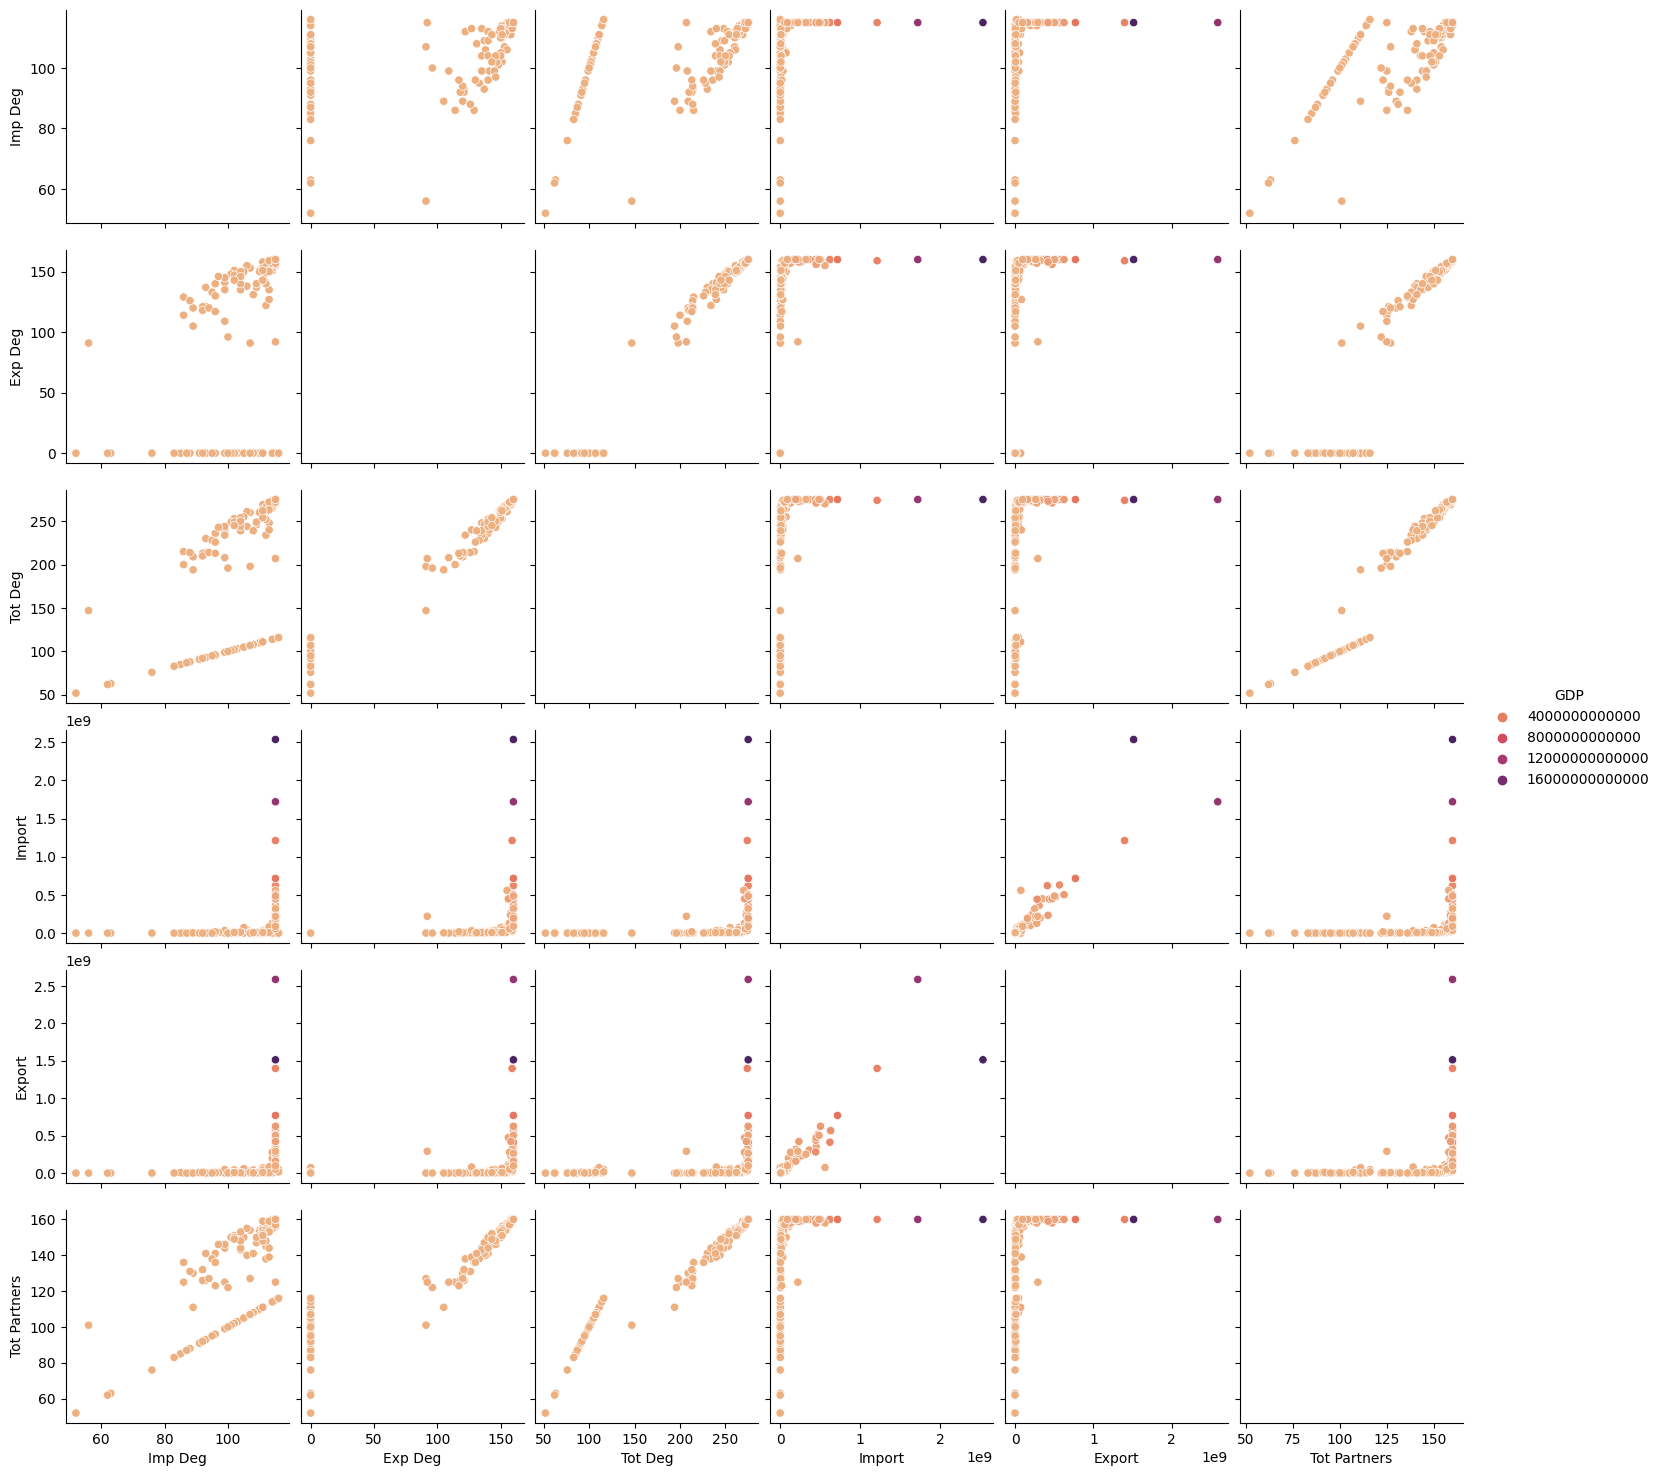

In [46]:
sns.pairplot(df_2018, hue = 'GDP'
             , diag_kind='auto',
             palette='flare'
            )